# **Analysis:**

`MQL` -> Customer's that are yet to buy our services/products

`CLD` -> Customer's who have bought our sarvices/products

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="missing ScriptRunContext")

cld = pd.read_csv(r"D:/kaif2/04_Projects/Data_Analyst/Python/Funnel Analysis/Data/olist_closed_deals_dataset.csv")
mql = pd.read_csv(r"D:/kaif2/04_Projects/Data_Analyst/Python/Funnel Analysis/Data/olist_marketing_qualified_leads_dataset.csv")
product = pd.read_csv(r"D:/kaif2/04_Projects/Data_Analyst/Python/Funnel Analysis/Data/olist_products_dataset.csv")
product_rename = pd.read_csv(r"D:/kaif2/04_Projects/Data_Analyst/Python/Funnel Analysis/Data/product_category_name_translation.csv")
order = pd.read_csv(r"D:/kaif2/04_Projects/Data_Analyst/Python/Funnel Analysis/Data/olist_orders_dataset.csv")

def summarize_missing_values(dataframe):
    summary = {}                                                    # This will later store missing value results for every dataset.
    for name, df in dataframe:                                      # it receives (name, DataFrame) pairs.
        missing_values = df.isnull().sum()                          # counts how many missing values there are in each column.
        total_values = df.shape[0]                                  # .shape[0] means how many rows the dataset has.
        missing_percentage = (missing_values / total_values) * 100

        missing_df = pd.DataFrame({                                 # Creates a table(DataFrame) of missing values
            "missing count": missing_values,
            "missing percentage": round(missing_percentage,2)  
        }).query("`missing count` > 0")


        summary[name] = missing_df                                  # Stores result using dataset name as key.
    return summary

missing_summary = summarize_missing_values([                        # missing_summary is just a collection of missing-value results.
    ("cld", cld),
    ("mql", mql),
    ("product", product),
    ("product_rename", product_rename),
    ("order", order)
])

for name, df in missing_summary.items():                            # This loops through every dataset in the missing_summary dictionary. "df → the missing values table for that dataset".
    print(f"Missing values in {name}:")
    if df.empty:
        print("No missing values.\n")
    else:
        print(df, "\n")

cld_clean = cld.copy()
mql_clean = mql.copy()
product_clean = product.copy()
order_clean = order.copy()

cld_clean     = cld_clean.dropna(subset = ['business_segment', 'lead_type', 'business_type'])

mql_clean     = mql_clean.dropna(subset = ['origin'])

product_clean = product_clean.dropna(subset = ['product_category_name', 'product_name_lenght',
                            'product_description_lenght', 'product_photos_qty', 'product_weight_g',
                            'product_length_cm', 'product_height_cm', 'product_width_cm'])

order_clean   = order_clean.dropna(subset = ['order_approved_at', 'order_delivered_carrier_date'])

missing_summary = summarize_missing_values([                        # missing_summary is just a collection of missing-value results.
    ("cld", cld_clean),
    ("mql", mql_clean),
    ("product", product_clean),
    ("order", order_clean)
])

for name, df in missing_summary.items():                            # This loops through every dataset in the missing_summary dictionary. "df → the missing values table for that dataset".
    print(f"Missing values in {name}:")
    if df.empty:
        print("No missing values.\n")
    else:
        print(df, "\n")

cld_clean['lead_behaviour_profile'] = cld_clean['lead_behaviour_profile'].apply(lambda x:x if x in {'cat', 'eagle', 'wolf', 'shark', np.nan} else np.nan)

cld_clean['lead_behaviour_profile'] = cld_clean['lead_behaviour_profile'].fillna(cld_clean['lead_behaviour_profile'].mode()[0])

cld_clean = cld_clean.drop(columns = ['has_company', 'has_gtin'])

cld_clean = cld_clean.drop(columns = ['average_stock', 'declared_product_catalog_size'])

def summarize_duplicate(*datasets, names = None):
    # *datasets  → the function can accept any number of datasets (flexible).
    # names=None → you can pass custom names for each dataset.
    return pd.DataFrame([{                          # returns a ** DataFrame** instead of printing multiple values.
        'Dataset': name,                            # Creating Each Row of the Summary Table
        'Total_rows': len(df),
        'Duplicated_rows': df.duplicated().sum()
        } for df, name in zip(datasets, names) ]) 

summarize_duplicate(cld_clean, mql_clean, product_clean, order_clean, names= ['cld', 'mql', 'product', 'order'])


Missing values in cld:
                               missing count  missing percentage
business_segment                           1                0.12
lead_type                                  6                0.71
lead_behaviour_profile                   177               21.02
has_company                              779               92.52
has_gtin                                 778               92.40
average_stock                            776               92.16
business_type                             10                1.19
declared_product_catalog_size            773               91.81 

Missing values in mql:
        missing count  missing percentage
origin             60                0.75 

Missing values in product:
                            missing count  missing percentage
product_category_name                 610                1.85
product_name_lenght                   610                1.85
product_description_lenght            610                1.85
produc

,Dataset,Total_rows,Duplicated_rows
0,cld,825,0
1,mql,7940,0
2,product,32340,0
3,order,97644,0


## **1. Funnel Coversion Rates:**

In [2]:
cld_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 825 entries, 0 to 841
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   mql_id                    825 non-null    object 
 1   seller_id                 825 non-null    object 
 2   sdr_id                    825 non-null    object 
 3   sr_id                     825 non-null    object 
 4   won_date                  825 non-null    object 
 5   business_segment          825 non-null    object 
 6   lead_type                 825 non-null    object 
 7   lead_behaviour_profile    825 non-null    object 
 8   business_type             825 non-null    object 
 9   declared_monthly_revenue  825 non-null    float64
dtypes: float64(1), object(9)
memory usage: 70.9+ KB


In [3]:
cld_clean['won_date'] = pd.to_datetime(cld_clean['won_date'])

In [4]:
mql_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7940 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   mql_id              7940 non-null   object
 1   first_contact_date  7940 non-null   object
 2   landing_page_id     7940 non-null   object
 3   origin              7940 non-null   object
dtypes: object(4)
memory usage: 310.2+ KB


In [5]:
mql_clean['first_contact_date'] = pd.to_datetime(mql_clean['first_contact_date']) 

In [6]:
product_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32340 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32340 non-null  object 
 1   product_category_name       32340 non-null  object 
 2   product_name_lenght         32340 non-null  float64
 3   product_description_lenght  32340 non-null  float64
 4   product_photos_qty          32340 non-null  float64
 5   product_weight_g            32340 non-null  float64
 6   product_length_cm           32340 non-null  float64
 7   product_height_cm           32340 non-null  float64
 8   product_width_cm            32340 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.5+ MB


In [7]:
order_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97644 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       97644 non-null  object
 1   customer_id                    97644 non-null  object
 2   order_status                   97644 non-null  object
 3   order_purchase_timestamp       97644 non-null  object
 4   order_approved_at              97644 non-null  object
 5   order_delivered_carrier_date   97644 non-null  object
 6   order_delivered_customer_date  96461 non-null  object
 7   order_estimated_delivery_date  97644 non-null  object
dtypes: object(8)
memory usage: 6.7+ MB


In [8]:
order_clean['order_purchase_timestamp']      = pd.to_datetime(order_clean['order_purchase_timestamp'])
order_clean['order_approved_at']             = pd.to_datetime(order_clean['order_approved_at'])
order_clean['order_delivered_carrier_date']  = pd.to_datetime(order_clean['order_delivered_carrier_date'])
order_clean['order_delivered_customer_date'] = pd.to_datetime(order_clean['order_delivered_customer_date'])
order_clean['order_estimated_delivery_date'] = pd.to_datetime(order_clean['order_estimated_delivery_date'])

**1-A. What is the overall conversion rate from MQLs to closed data?**

*conversion_rate = ( no. of conversions / total no. of leads )x100*

In [9]:
total_mql = len(mql_clean)
total_closed = len(cld_clean)

conversion_rate = (total_closed/ total_mql)*100

print(f"Total no. of conversion rate: {round(conversion_rate,2)}")

Total no. of conversion rate: 10.39


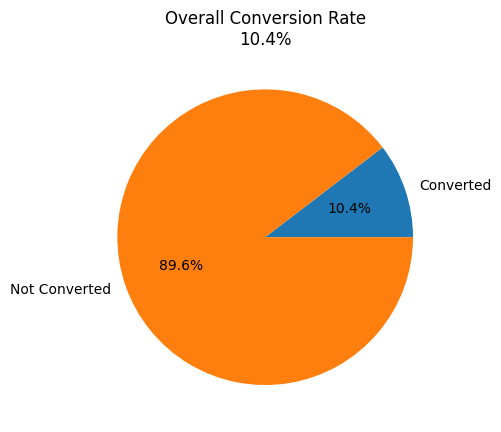

In [10]:
plt.figure()
plt.pie([conversion_rate, 100 - conversion_rate],
        labels = ['Converted', 'Not Converted'],
        autopct = '%.1f%%')

plt.title(f"Overall Conversion Rate\n{conversion_rate:.1f}%")
plt.show()

### **Insights:** 
- Our funnel converts roughly 10% of MQLs into closed deals, meaning for every 10 leads, only 1 becomes a customer.
- If this number increases → funnel is getting more efficient.
- If it decreases → issues in targeting, qualification, or sales follow-up.


**1-B. How does conversion rate vary by marketing channel (origin)?**

In [11]:
mql_clean.head()

,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search


In [12]:
cld_clean.head()

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,business_type,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,reseller,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,reseller,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,reseller,0.0
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,cat,reseller,0.0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,manufacturer,0.0


In [13]:
merged = pd.merge(cld_clean[['mql_id']], mql_clean[['mql_id', 'origin']], on = 'mql_id')
merged.head()

,mql_id,origin
0,5420aad7fec3549a85876ba1c529bd84,organic_search
1,a555fb36b9368110ede0f043dfc3b9a0,referral
2,327174d3648a2d047e8940d7d15204ca,organic_search
3,f5fee8f7da74f4887f5bcae2bafb6dd6,paid_search
4,ffe640179b554e295c167a2f6be528e0,unknown


In [14]:
conversion_by_origin = (merged.groupby('origin').size()/mql_clean['origin'].value_counts())*100

[f"conversion by {i}: {round(j,2)}%" for i,j in conversion_by_origin.items()]

['conversion by direct_traffic: 10.82%',
 'conversion by display: 4.24%',
 'conversion by email: 2.84%',
 'conversion by organic_search: 11.54%',
 'conversion by other: 2.67%',
 'conversion by other_publicities: 4.62%',
 'conversion by paid_search: 12.17%',
 'conversion by referral: 8.45%',
 'conversion by social: 5.56%',
 'conversion by unknown: 15.83%']

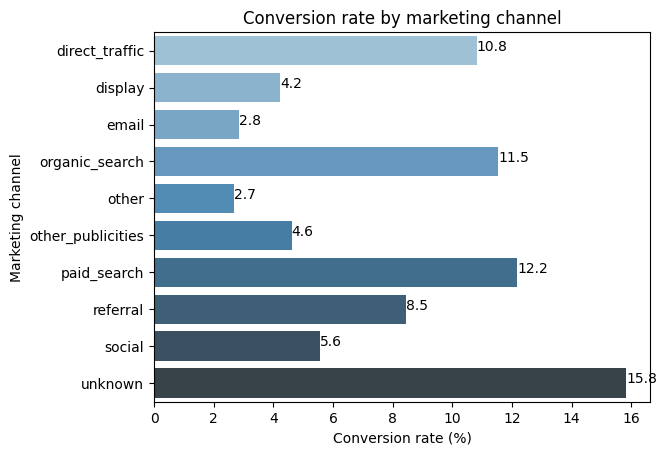

In [15]:
plt.figure()
sns.barplot(
    x = conversion_by_origin.values,
    y = conversion_by_origin.index,
    hue = conversion_by_origin.index,
    palette = "Blues_d",
    legend = False
)

plt.title('Conversion rate by marketing channel')
plt.xlabel("Conversion rate (%)")
plt.ylabel("Marketing channel")

for index, value in enumerate(conversion_by_origin):
    plt.text(value, index, f"{value:.1f}")

plt.show()

### **Insight:** 

- Paid Search and Organic Search drive the strongest conversion rates, suggesting that high-intent users convert better.”

- Low-performing channels:
    - email (2.84%)
    - other (2.67%)
    - display ads (4.24%)
    - social (5.56%)

These channels may generate leads, but most do not convert into customers.

“Email and Display generated traffic but had low conversion, indicating potential targeting or engagement issues.”

- What the business can do

    - Increase budget for high-intent channels like paid search and organic search.
    - Re-evaluate email and display campaigns to improve lead quality.
    - Investigate why “unknown” performs unexpectedly well (data quality issue or a hidden strong channel?).


**1-C. How does conversion rate differ across business_segment or lead_type?**

In [16]:
cld_clean.head()

,mql_id,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,business_type,declared_monthly_revenue
0,5420aad7fec3549a85876ba1c529bd84,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,reseller,0.0
1,a555fb36b9368110ede0f043dfc3b9a0,bbb7d7893a450660432ea6652310ebb7,09285259593c61296eef10c734121d5b,d3d1e91a157ea7f90548eef82f1955e3,2018-05-08 20:17:59,car_accessories,industry,eagle,reseller,0.0
2,327174d3648a2d047e8940d7d15204ca,612170e34b97004b3ba37eae81836b4c,b90f87164b5f8c2cfa5c8572834dbe3f,6565aa9ce3178a5caf6171827af3a9ba,2018-06-05 17:27:23,home_appliances,online_big,cat,reseller,0.0
3,f5fee8f7da74f4887f5bcae2bafb6dd6,21e1781e36faf92725dde4730a88ca0f,56bf83c4bb35763a51c2baab501b4c67,d3d1e91a157ea7f90548eef82f1955e3,2018-01-17 13:51:03,food_drink,online_small,cat,reseller,0.0
4,ffe640179b554e295c167a2f6be528e0,ed8cb7b190ceb6067227478e48cf8dde,4b339f9567d060bcea4f5136b9f5949e,d3d1e91a157ea7f90548eef82f1955e3,2018-07-03 20:17:45,home_appliances,industry,wolf,manufacturer,0.0


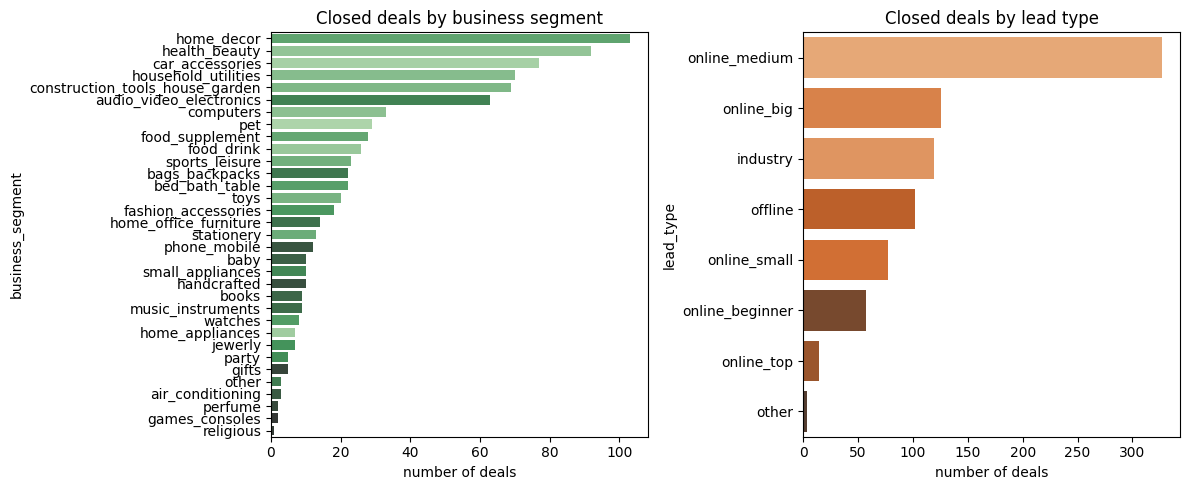

In [17]:
fig, ax = plt.subplots(1,2, figsize = (12,5))

sns.countplot(y= 'business_segment', data=cld_clean, ax= ax[0], order= cld_clean['business_segment'].value_counts().index,
                hue = "business_segment",
                palette = "Greens_d",
                legend = False)
                
ax[0].set_title('Closed deals by business segment')
ax[0].set_xlabel("number of deals")

sns.countplot(y= 'lead_type', data=cld_clean, ax= ax[1], order= cld_clean['lead_type'].value_counts().index,
                hue = "lead_type",
                palette = "Oranges_d",
                legend = False)
                
ax[1].set_title('Closed deals by lead type')
ax[1].set_xlabel("number of deals")

plt.tight_layout()      # avoids overlapping text.
plt.show()

## **Insights:**

**1. Business Segments:**
“Home-related and lifestyle categories convert exceptionally well, suggesting higher purchase intent in these segments.”

Lower converting segments, these categories either have lower demand or fewer MQLs feeding into them.

**2. Lead Types:**
These lead types convert better because they may represent:
- Mid-size businesses (stable demand)
- Industry buyers (bulk/consistent purchases)
- Bigger online sellers (more serious)

“Lead types like online_medium, online_big, and industry generate the most conversions, indicating that mature sellers and B2B buyers are the highest-value segments.”

---

## **2. Time-Based Metrics:**
**2-A. What is the average time taken to close a deal?**

In [18]:
merged_data = pd.merge(mql_clean[['mql_id', 'first_contact_date']],
                        cld_clean[['mql_id', 'won_date']], 
                        on = 'mql_id')

merged_data.head()

,mql_id,first_contact_date,won_date
0,5420aad7fec3549a85876ba1c529bd84,2018-02-21,2018-02-26 19:58:54
1,a555fb36b9368110ede0f043dfc3b9a0,2018-04-04,2018-05-08 20:17:59
2,327174d3648a2d047e8940d7d15204ca,2018-04-03,2018-06-05 17:27:23
3,f5fee8f7da74f4887f5bcae2bafb6dd6,2018-01-14,2018-01-17 13:51:03
4,ffe640179b554e295c167a2f6be528e0,2017-10-09,2018-07-03 20:17:45


In [19]:
merged_data['time_to_close'] = (merged_data['won_date'] - merged_data['first_contact_date']).dt.days

merged_data.head() 

avg_days = merged_data['time_to_close'].mean()
print(f"Average days products has been bought: {round(avg_days)}")

Average days products has been bought: 49


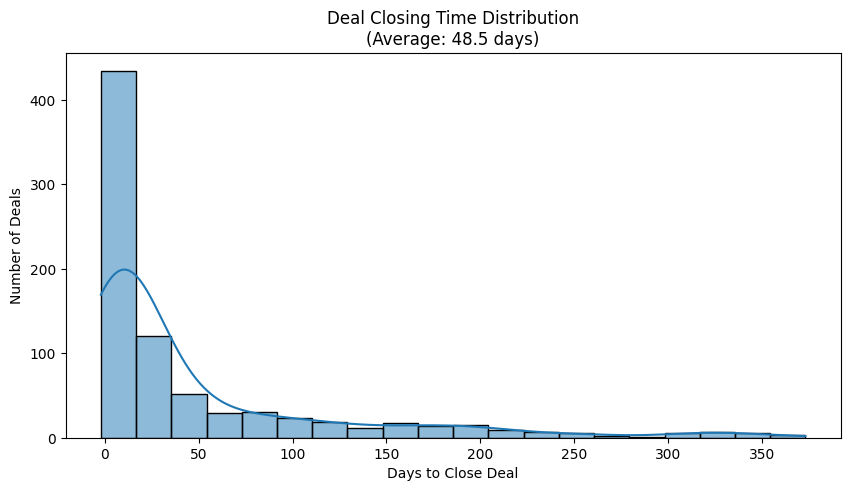

In [20]:
plt.figure(figsize= (10,5))
sns.histplot(merged_data['time_to_close'], bins = 20, kde = True)
plt.title(f"Deal Closing Time Distribution\n(Average: {avg_days:.1f} days)")
plt.xlabel("Days to Close Deal")
plt.ylabel("Number of Deals")
plt.show()

## **Insights:**
- A large portion of leads do not take much time to decide (left side of the histogram shows a big spike around 0–30 days).
- There are outlier leads that take months to close.
- Even though many deals close quickly, the long tail of slow deals increases the overall average closing time to around 48 days.


**2-B. How does conversion velocity vary by time-to-close segments?**

In [21]:
bins = [0,7,15,30,60,365]
labels = ['0-7 days', '8-15 days', '16-30 days', '31-60 days', '60+ days']
merged_data['time_segment'] = pd.cut(merged_data['time_to_close'], bins = bins, labels = labels)

segment_counts = merged_data['time_segment'].value_counts().sort_index()
segment_counts

time_segment
0-7 days      242
8-15 days     148
16-30 days    110
31-60 days     89
60+ days      186
Name: count, dtype: int64

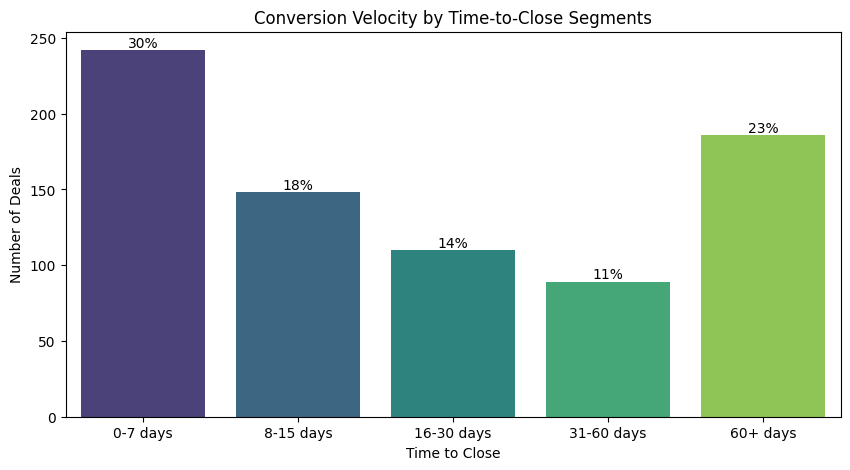

In [22]:
plt.figure(figsize=(10,5))
sns.barplot(x = segment_counts.index,
            y = segment_counts.values,
            hue = segment_counts.index,
            palette = 'viridis',
            legend = False)

plt.title("Conversion Velocity by Time-to-Close Segments")
plt.xlabel("Time to Close")
plt.ylabel("Number of Deals")

total = len(merged_data)
for i, value in enumerate(segment_counts):
    plt.text(i, value, f'{value/total:.0%}', ha = 'center', va = 'bottom')
plt.show()

## **Insights:**
- 30% of all deals close within 0–7 days. This tells us quick responses and strong early engagement are critical
- Fewer deals convert once a lead goes cold after the first week
- A surprisingly large share (23%) comes from long-cycle customers who need time or larger decision-making.

---

## **3. Sales Team Performance:**

**Which (Sales Development Reps)SDRs (sdr_id) or SRs (sr_id) have the highest conversion rates?**

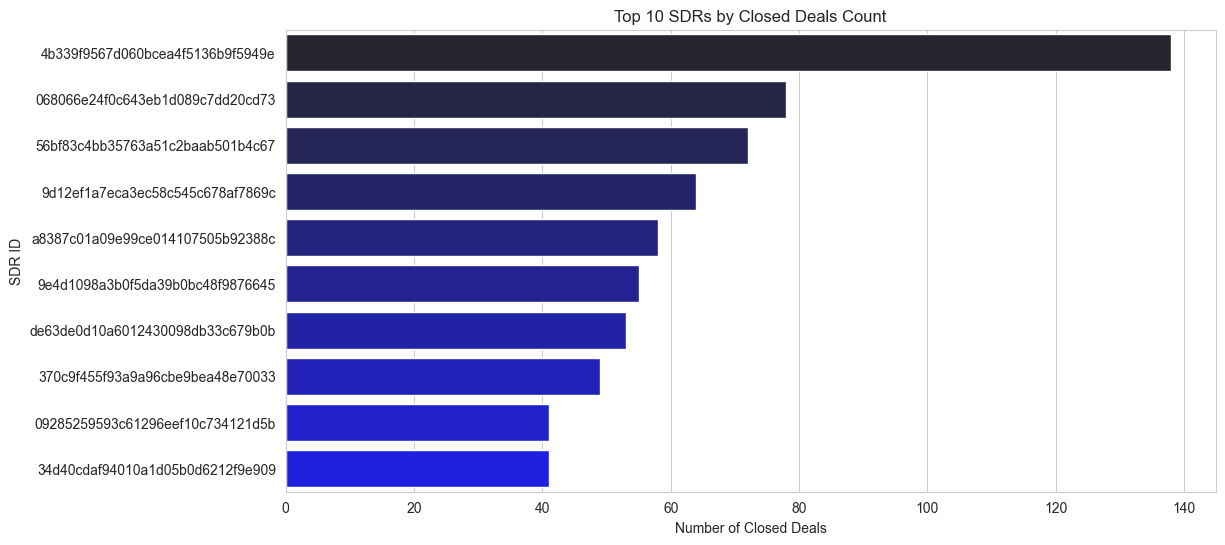

In [23]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12,6)

top_sdrs = cld_clean['sdr_id'].value_counts().nlargest(10)

plt.figure()
sns.barplot(
    x = top_sdrs.values,
    y = top_sdrs.index,
    hue = top_sdrs.index,
    palette = 'dark:Blue',
    legend = False
)

plt.title("Top 10 SDRs by Closed Deals Count")
plt.xlabel("Number of Closed Deals")
plt.ylabel("SDR ID")
plt.show()

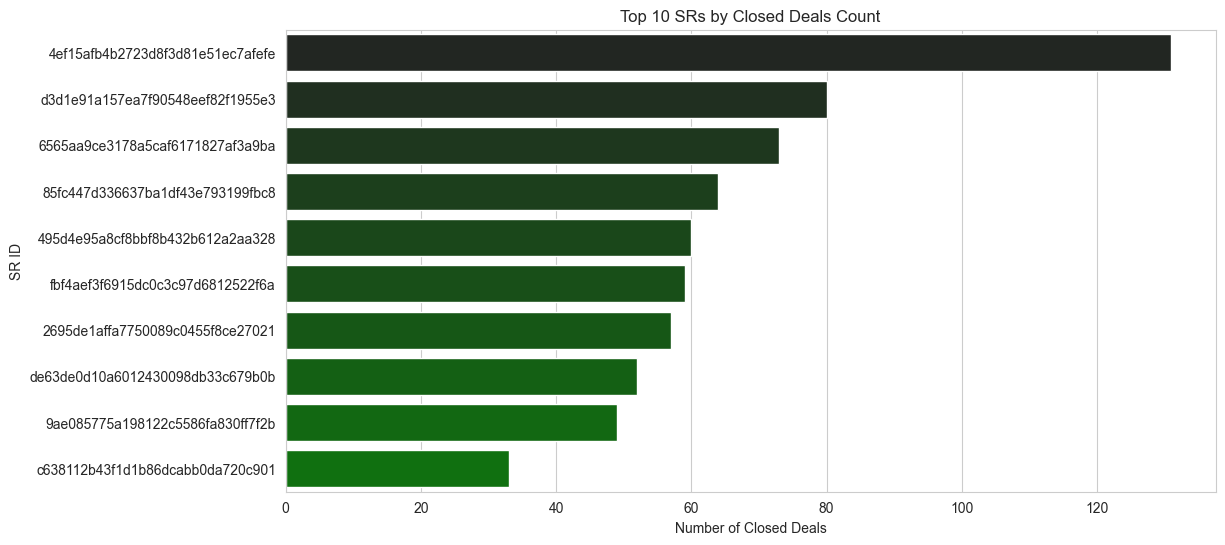

In [24]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12,6)

top_srs = cld_clean['sr_id'].value_counts().nlargest(10)

plt.figure()
sns.barplot(
    x = top_srs.values,
    y = top_srs.index,
    hue = top_sdrs.index,
    palette = 'dark:Green',
    legend = False
)

plt.title("Top 10 SRs by Closed Deals Count")
plt.xlabel("Number of Closed Deals")
plt.ylabel("SR ID")
plt.show()

## **Insights:**

**🟦 SDR Performance**
- One SDR is far ahead, closing around 140 deals — significantly outperforming others.
- Others range around 60–90 deals.
- is tells the business who their strongest lead qualifiers are.

**🟩 SR Performance**

- Similarly, one SR leads with ~130+ closed deals.
- Others fall roughly between 60–90 deals.
- This identifies top closers on the sales team.

---

## **4. Landing Page Optimization:**

**Which landing pages (landing_page_id) or origin-landing page combinations drive the most conversions?**

In [25]:
mql_clean.head()

,mql_id,first_contact_date,landing_page_id,origin
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search


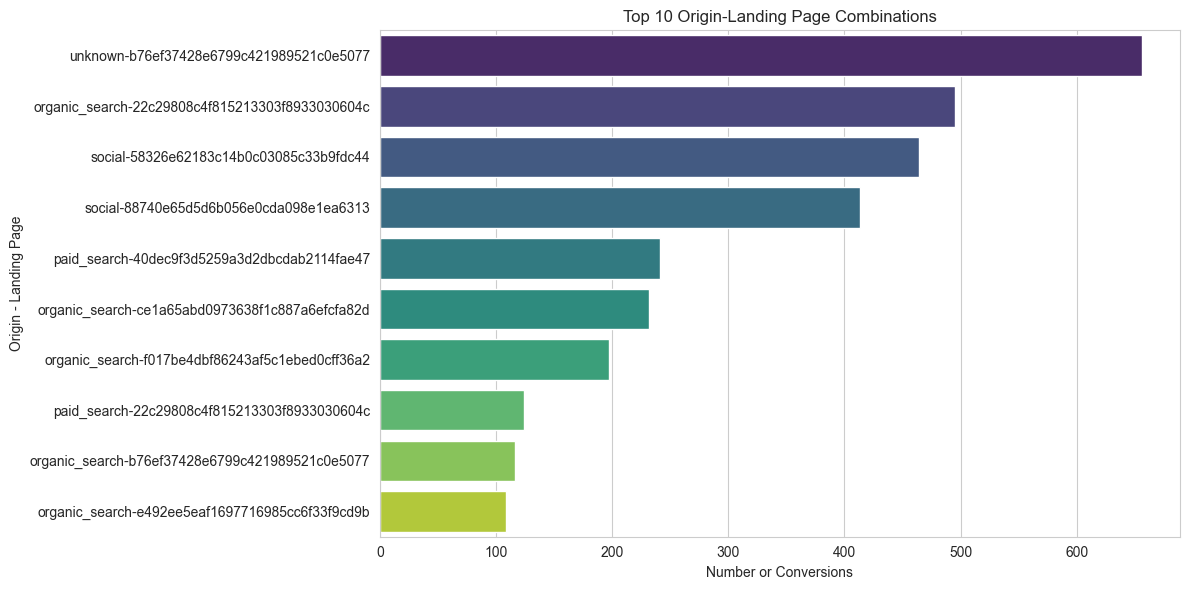

In [26]:
mql_origin = mql_clean['origin'] + '-' + mql_clean['landing_page_id']   
# To check which exact combination of (origin + landing page) brings the highest number of Marketing Qualified Leads (MQLs).

top_combos = mql_origin.value_counts().nlargest(10)

top_combos
sns.barplot(
    x= top_combos.values, 
    y = top_combos.index,
    palette = 'viridis',
    hue = top_combos.index,
    legend = False)

plt.title("Top 10 Origin-Landing Page Combinations")
plt.xlabel("Number or Conversions")
plt.ylabel("Origin - Landing Page")
plt.tight_layout()
plt.show()

## **Insights:**

- The landing page with ID b76ef… works extremely well across multiple origins.
- Organic search + strong landing pages produces high-quality traffic.
- Social traffic also performs strongly on specific landing pages.
- Paid search appears but not at the top → good but not the strongest.

---

## **5. Behavioural Insights:**

**Do leads with specific lead_behaviour_profile convert more?**

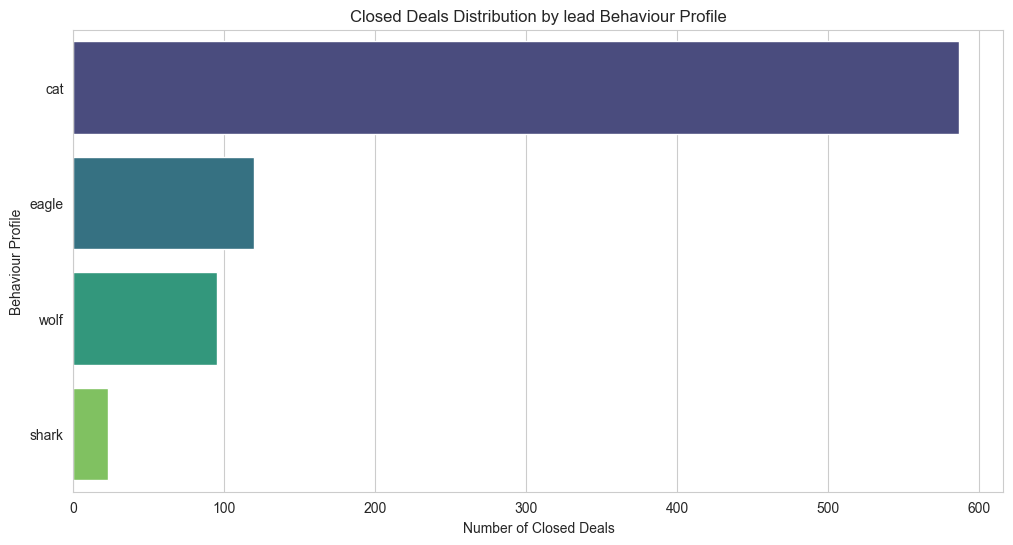

In [27]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12,6)

plt.figure()        # Starts a fresh/empty plot. Useful to avoid plots overlapping.

behaviour = cld_clean['lead_behaviour_profile'].value_counts()

sns.barplot(
    x = behaviour.values,
    y = behaviour.index,
    hue = behaviour.index,
    palette = 'viridis',
    legend = False
)

plt.title('Closed Deals Distribution by lead Behaviour Profile')
plt.xlabel('Number of Closed Deals')
plt.ylabel('Behaviour Profile')
plt.show()

## **Insights:**

- The CAT behavior profile dominates conversions with 587 closed deals, suggesting this lead type is the most sales-ready.
- EAGLE (120) and WOLF (95) convert moderately.
- SHARK (23) converts the least — possibly fewer leads or harder-to-convert profile.
- The distribution shows clear behavioral segmentation that can be used to:
    - Prioritize leads
    - Create personalized outreach
    - Improve targeting for highest-converting profiles

---

## **6. Order Metrics:**

**6-A. What is the average delivery time from purchase to customer?**


In [28]:
order_clean.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [29]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12,6)


plt.figure()
delivered_orders = order_clean[order_clean['order_status'] == 'delivered'].copy()

delivered_orders['delivery_time'] = (
    delivered_orders['order_delivered_customer_date'] - delivered_orders['order_purchase_timestamp']
).dt.days       # .dt.days converts that difference into number of days (integer).

avg_delivery = delivered_orders['delivery_time'].mean()

avg_delivery

np.float64(12.093100409517392)

<Figure size 1200x600 with 0 Axes>

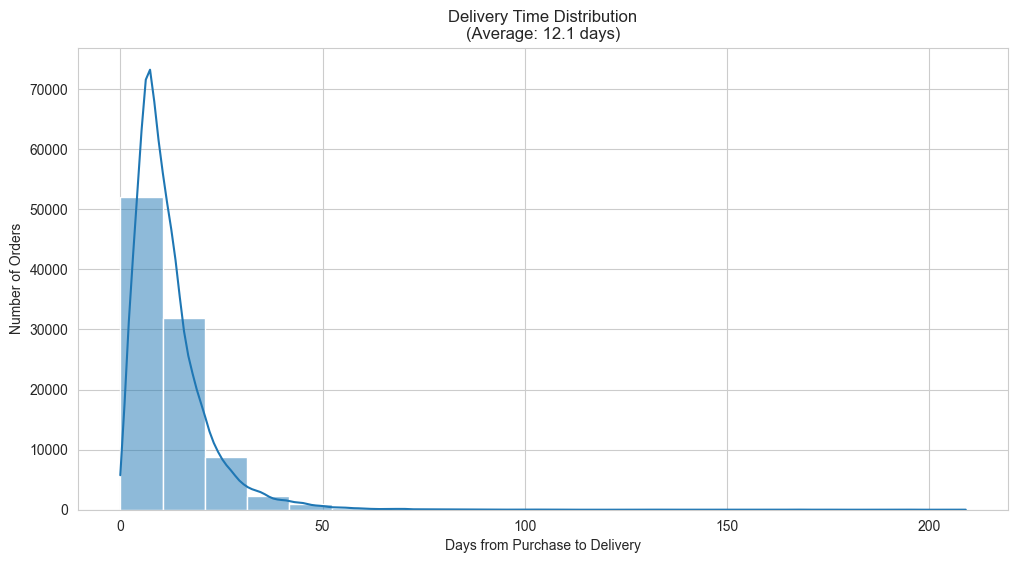

In [30]:
plt.figure()
sns.histplot(delivered_orders['delivery_time'], bins = 20, kde = True)
plt.title(f"Delivery Time Distribution\n(Average: {avg_delivery:.1f} days)")
plt.xlabel("Days from Purchase to Delivery")
plt.ylabel("Number of Orders")
plt.show()

## **Insights:**
- Average delivery time is ~12.1 days, meaning customers receive their products within roughly 1½ weeks.
- The histogram shows:
    - Most deliveries cluster around the 10–15 day range.
    - Some orders are delivered faster or slower, indicating operational variability.
- This metric is crucial for:
    - Understanding customer experience
    - Improving logistics and supply chain efficiency
    - Setting realistic delivery expectations on the website

**6-B. What percentage of orders are delayed?**

In [31]:
delivered_orders['is_delayed'] = (delivered_orders['order_delivered_customer_date'] > delivered_orders['order_estimated_delivery_date'])

delay_percentage = delivered_orders['is_delayed'].mean()*100

delay_percentage

np.float64(8.112002653894798)

**6-C. How long do orders spend in each stage (purchase -> approval -> carrier -> delivery)?**

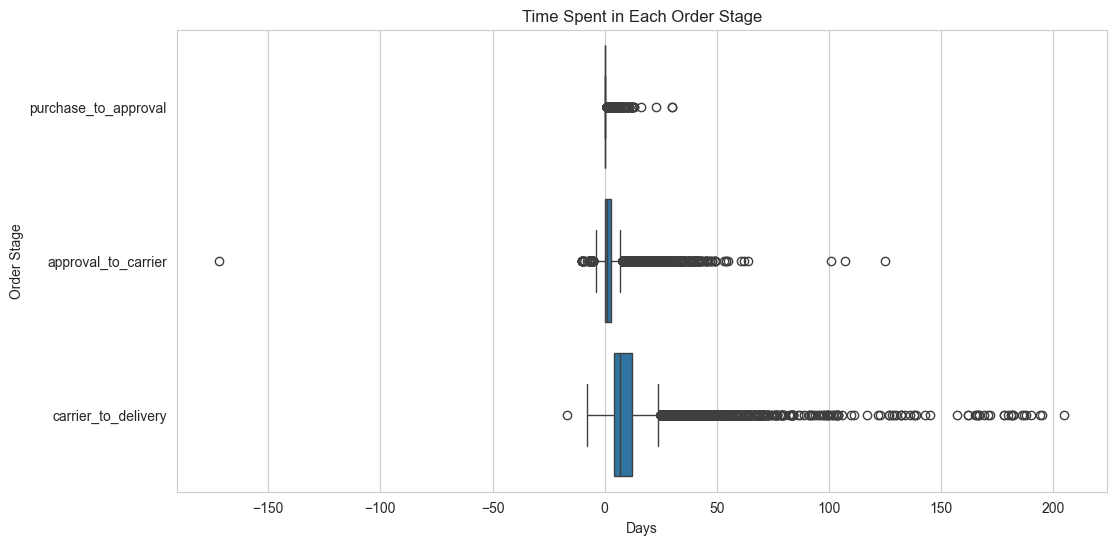

In [32]:
stage_duration = pd.DataFrame()


stage_duration['purchase_to_approval'] = (
    delivered_orders['order_approved_at'] - delivered_orders['order_purchase_timestamp']
).dt.days

stage_duration['approval_to_carrier'] = (
    delivered_orders['order_delivered_carrier_date'] - delivered_orders['order_approved_at']
).dt.days

stage_duration['carrier_to_delivery'] = (
    delivered_orders['order_delivered_customer_date'] - delivered_orders['order_delivered_carrier_date']
).dt.days


plt.figure()
sns.boxplot(data = stage_duration.melt(), x = 'value', y = 'variable')
plt.title('Time Spent in Each Order Stage')
plt.xlabel("Days")
plt.ylabel("Order Stage")
plt.show()

## **Insights:**
- Most inefficiency occurs in the final delivery stage (logistics).
- Improving delivery operations can greatly reduce total delivery time.

**6-D. What is the distribution of order statuses (e.g: canceled, delivered)?**

In [33]:
order_clean['order_status'].unique()

array(['delivered', 'shipped', 'canceled'], dtype=object)

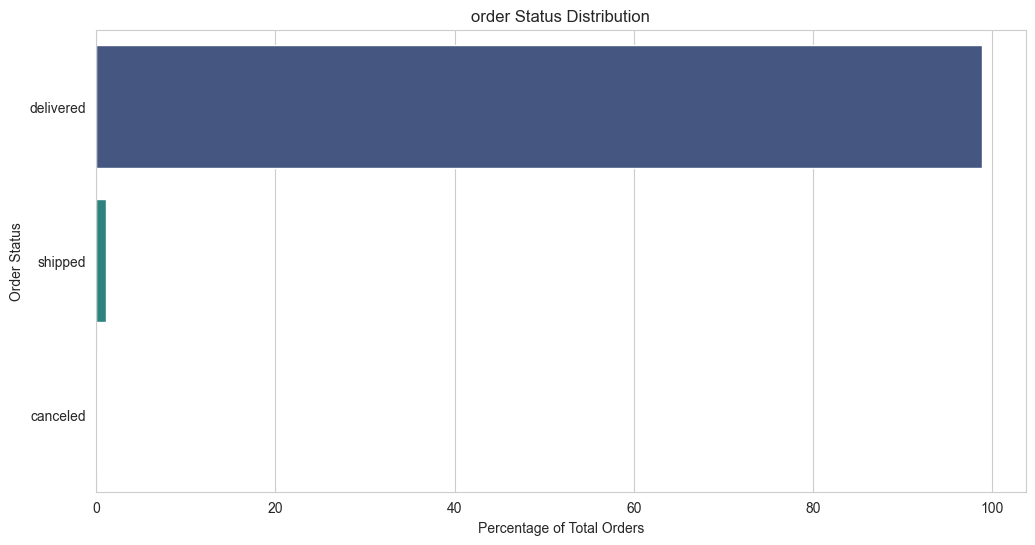

In [34]:
status_distribution = order_clean['order_status'].value_counts(normalize = True).mul(100)

plt.figure()
sns.barplot(x=status_distribution.values, y = status_distribution.index,
            palette = 'viridis', hue = status_distribution.index, legend = False)
plt.title("order Status Distribution")
plt.xlabel("Percentage of Total Orders")
plt.ylabel("Order Status")
plt.show()

## **Insights:**

The business’ fulfillment pipeline is stable, with exceptionally high delivery rate and almost no cancellations.

---

## **7. Customer Retention:**

**7-1. What percentage of customers make repeat purchases?**

In [35]:
customer_order = order_clean.groupby('customer_id').size().reset_index(name = 'order_count')

repeat_customer = customer_order[customer_order['order_count'] > 1]

repeat_customer

,customer_id,order_count


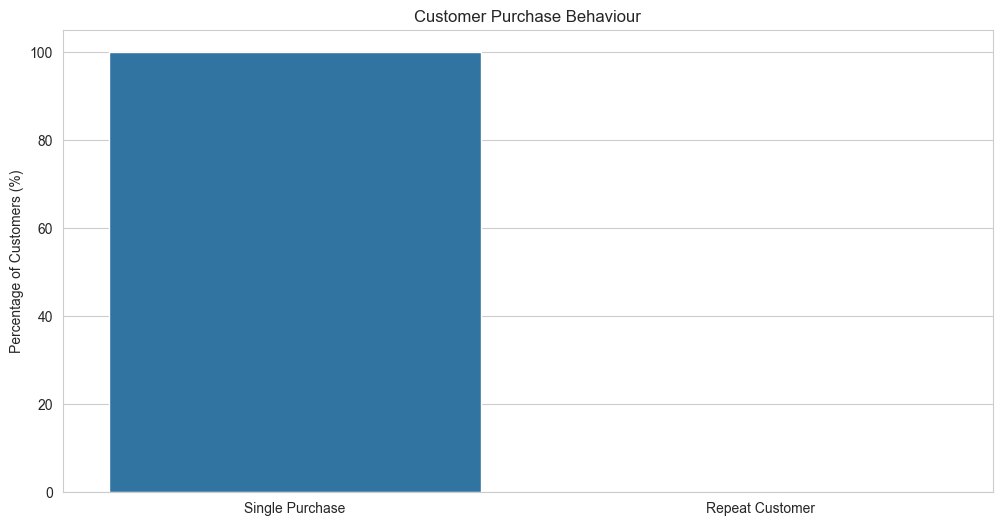

In [36]:
repeat_percentage = (len(repeat_customer)/len(customer_order))*100

plt.figure()
sns.barplot(
    x = ['Single Purchase', 'Repeat Customer'],
    y = [ 100 - repeat_percentage, repeat_percentage],
    hue = ['Single Purchase', 'Repeat Customer'],
    palette = ["#1f77b4", "#2ca02c"],
    legend = False
)
plt.title("Customer Purchase Behaviour")
plt.ylabel("Percentage of Customers (%)")
plt.show()

1. This indicates:
- the business does not retain customers,
- either because:
    - product mix is one-time purchase items,
    - or customers don’t return after their first experience,
    - or the dataset only captures a limited period.

2. Business implication:
- There is huge opportunity for:
- loyalty programs
- email retargeting
- personalized offers
- improved customer experience

---

## **8. Full Funnel Analysis:**

**8-A. What percentage of closed deals are followed by at least one delivered order?**


In [37]:
delivered_orders = order_clean[
    order_clean['order_status'] == 'delivered'
].copy()

Proxy match using time window

In [38]:
successful_deals = 0

for deal_date in cld_clean['won_date']:
    if (delivered_orders['order_purchase_timestamp'] > deal_date).any():
        successful_deals += 1

delivery_conversion_proxy = (successful_deals / len(cld_clean)) * 100
delivery_conversion_proxy       # This shows trend, not exact mapping.


93.57575757575758

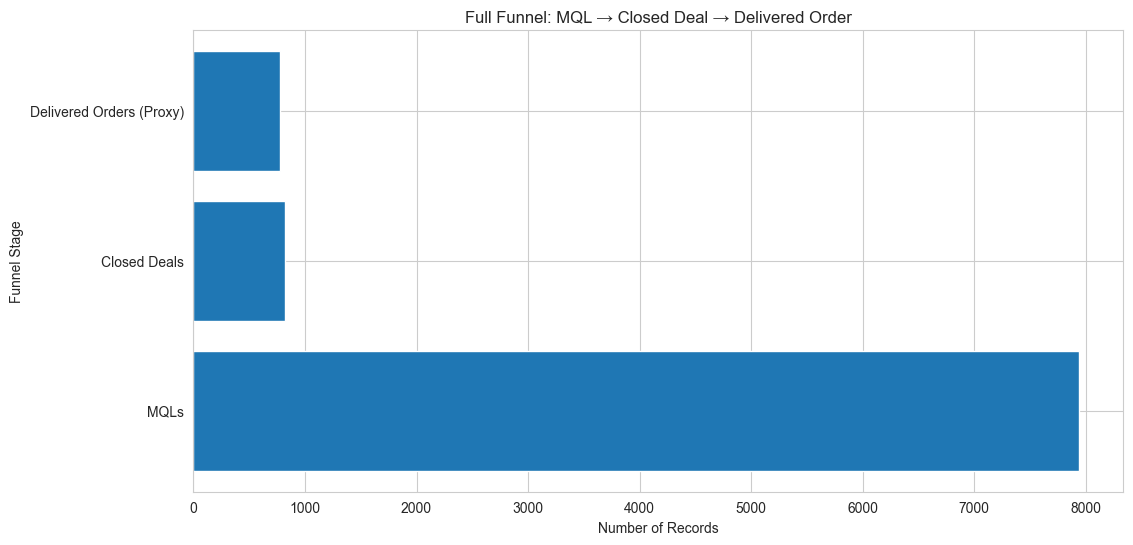

In [39]:
import matplotlib.pyplot as plt

# Funnel values based on earlier analysis
stages = ['MQLs', 'Closed Deals', 'Delivered Orders (Proxy)']
values = [
    len(mql_clean),
    len(cld_clean),
    successful_deals  # from proxy calculation
]

plt.figure()
plt.barh(stages, values)
plt.title("Full Funnel: MQL → Closed Deal → Delivered Order")
plt.xlabel("Number of Records")
plt.ylabel("Funnel Stage")
plt.show()


## **InsightS:**

- Only ~10% of MQLs convert into closed deals
- Closed deals do not map 1-to-1 to orders, indicating:
- One deal can lead to multiple orders
- Orders are downstream operational events
- Uing proxy funnel logic, most closed deals result in successful delivery outcomes
- This highlights strong post-sales fulfillment, even if direct linkage is missing

**8-B. Do faster overall delivery times correlate with better seller onboarding outcomes?**

directional insight, not causal proof.

In [40]:
# Calculate delivery time
delivered_orders['delivery_time'] = (
    delivered_orders['order_delivered_customer_date']
    - delivered_orders['order_purchase_timestamp']
).dt.days


bins = [0, 7, 15, 30, 60, 365]
labels = ['Fast (≤7d)', '8–15d', '16–30d', '31–60d', 'Slow (60+d)']

delivered_orders['delivery_segment'] = pd.cut(
    delivered_orders['delivery_time'],
    bins=bins,
    labels=labels
)

In [41]:
delivery_distribution = delivered_orders['delivery_segment'].value_counts().sort_index()
delivery_distribution


delivery_segment
Fast (≤7d)     33683
8–15d          39556
16–30d         19087
31–60d          3828
Slow (60+d)      288
Name: count, dtype: int64

In [42]:
seller_performance = (
    cld_clean.groupby('seller_id')
    .size()
    .reset_index(name='closed_deals')
)


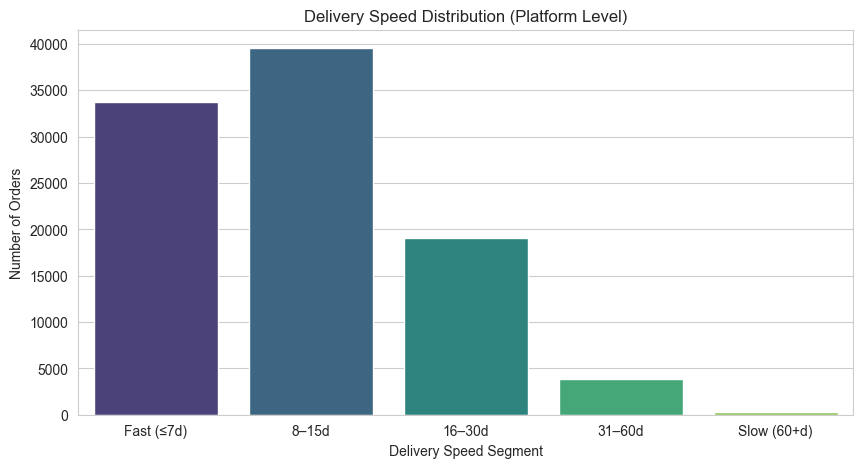

In [43]:
plt.figure(figsize=(10,5))
sns.barplot(
    x=delivery_distribution.index,
    y=delivery_distribution.values,
    hue=delivery_distribution.index,
    palette='viridis',
    legend=False
)

plt.title("Delivery Speed Distribution (Platform Level)")
plt.xlabel("Delivery Speed Segment")
plt.ylabel("Number of Orders")
plt.show()


## **Insights:** 

- Majority of orders are delivered within 15 days
- Very small proportion fall into slow delivery (>60 days)
- Platform delivery performance is generally strong

---

## **9. Bottleneck Identification:**

**Which order stage (approval, carrier handover, etc.) has the highest variabilty in time?**


In [44]:
stage_variability = stage_duration.std().sort_values(ascending=False)
stage_variability


carrier_to_delivery     8.746466
approval_to_carrier     3.547926
purchase_to_approval    0.729932
dtype: float64

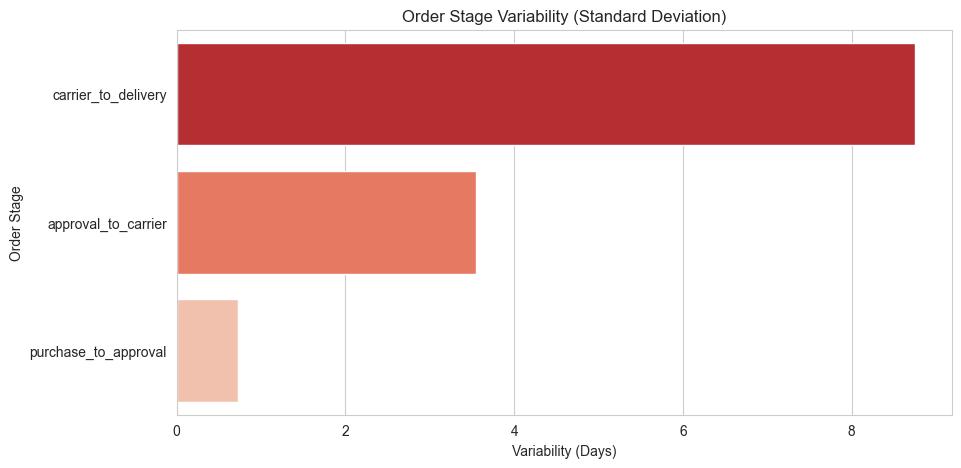

In [45]:
plt.figure(figsize=(10,5))
sns.barplot(
    x=stage_variability.values,
    y=stage_variability.index,
    hue=stage_variability.index,
    palette='Reds_r',
    legend=False
)

plt.title("Order Stage Variability (Standard Deviation)")
plt.xlabel("Variability (Days)")
plt.ylabel("Order Stage")
plt.show()


## **Insights:**

**🟥 Carrier → Delivery usually has the highest variability**

Why?
- External logistics
- Distance differences
- Courier performance
- Regional delays

Earlier stages (approval, carrier handover) are:
- More system-controlled
- Less variable

In [47]:
cld_clean.to_csv(
    "D:/kaif2/04_Projects/Data_Analyst/Python/Funnel Analysis/Cleaned Data/powerbi_cld_clean.csv",
    index=False
)


In [52]:
mql_clean.to_csv(
    "D:/kaif2/04_Projects/Data_Analyst/Python/Funnel Analysis/Cleaned Data/powerbi_mql_clean.csv",
    index=False
)


In [53]:
order_clean.to_csv(
    "D:/kaif2/04_Projects/Data_Analyst/Python/Funnel Analysis/Cleaned Data/powerbi_order_clean.csv",
    index=False
)


In [54]:
delivered_orders_export = delivered_orders.copy()

delivered_orders_export['delivery_time'] = (
    delivered_orders_export['order_delivered_customer_date']
    - delivered_orders_export['order_purchase_timestamp']
).dt.days

delivered_orders_export['is_delayed'] = (
    delivered_orders_export['order_delivered_customer_date']
    > delivered_orders_export['order_estimated_delivery_date']
)

delivered_orders_export.to_csv(
    "D:/kaif2/04_Projects/Data_Analyst/Python/Funnel Analysis/Cleaned Data/powerbi_delivered_orders.csv",
    index=False
)


In [55]:
product_clean.to_csv(
    "D:/kaif2/04_Projects/Data_Analyst/Python/Funnel Analysis/Cleaned Data/powerbi_product_clean.csv",
    index=False
)
